In [1]:
import os
from pyspark.sql import SQLContext
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorIndexer, IndexToString
from pyspark.sql.types import IntegerType
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
import brunel
from dsx_ml.ml import save
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import dsx_core_utils, requests, os, io
from pyspark.sql import SparkSession
% matplotlib inline

In [2]:


# Add asset from file system
df_churn = SQLContext(sc).read.csv(os.environ['DSX_PROJECT_DIR']+'/datasets/Admission_Predict.csv', header='true', inferSchema = 'true')
df_churn.show(5)


+----------+---------+-----------+-----------------+---+----+----+--------+----------------+
|Serial No.|GRE Score|TOEFL Score|University Rating|SOP|LOR |CGPA|Research|Chance of Admit |
+----------+---------+-----------+-----------------+---+----+----+--------+----------------+
|         1|      337|        118|                4|4.5| 4.5|9.65|       1|            0.92|
|         2|      324|        107|                4|4.0| 4.5|8.87|       1|            0.76|
|         3|      316|        104|                3|3.0| 3.5| 8.0|       1|            0.72|
|         4|      322|        110|                3|3.5| 2.5|8.67|       1|             0.8|
|         5|      314|        103|                2|2.0| 3.0|8.21|       0|            0.65|
+----------+---------+-----------+-----------------+---+----+----+--------+----------------+
only showing top 5 rows



In [3]:
df_churn_pd = df_churn.toPandas()
df_churn_pd.head(5)

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


In [4]:
drop_list = ['Serial No.']

df_churn=df_churn.select([column for column in df_churn.columns if column not in drop_list])

In [5]:
df_churn

DataFrame[GRE Score: int, TOEFL Score: int, University Rating: int, SOP: double, LOR : double, CGPA: double, Research: int, Chance of Admit : double]

In [6]:
df_churn_pd['Chance of Admit ']= [1 if each > 0.7 else 0 for each in df_churn_pd['Chance of Admit ']]

In [7]:
from pyspark.sql import SQLContext
sqlCtx = SQLContext(sc)
df_churn = sqlCtx.createDataFrame(df_churn_pd)

In [8]:
df_churn.registerTempTable("ufo_sightings")

In [9]:
drop_list = ['Serial No.']

df_churn=df_churn.select([column for column in df_churn.columns if column not in drop_list])

In [10]:
categoricalColumns = []

In [11]:
non_categoricalColumns = df_churn.select([c for c in df_churn.columns if c not in categoricalColumns]).columns

In [12]:
print(non_categoricalColumns)

['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR ', 'CGPA', 'Research', 'Chance of Admit ']


In [13]:
non_categoricalColumns.remove('Chance of Admit ')

In [14]:

stages = []
for categoricalCol in categoricalColumns:
    # Category Indexing with StringIndexer
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + "Index")
    
    #Use OneHotEncoder to convert categorical variables into binary SparseVectors
    encoder = OneHotEncoder(inputCol=categoricalCol + "Index", outputCol=categoricalCol + "classVec")
    
    stages += [stringIndexer, encoder]

In [15]:
labelIndexer = StringIndexer(inputCol='Chance of Admit ', outputCol='label').fit(df_churn)

In [16]:
for colnum in non_categoricalColumns:
    df_churn = df_churn.withColumn(colnum, df_churn[colnum].cast(IntegerType()))

In [17]:

# Transform all features into a vector using VectorAssembler
assemblerInputs = [c + "classVec" for c in categoricalColumns] + non_categoricalColumns
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

In [18]:
# instantiate a random forest classifier, take the default settings
rf=RandomForestClassifier(labelCol="label", featuresCol="features")

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=labelIndexer.labels)

stages += [labelIndexer, assembler, rf, labelConverter]

pipeline = Pipeline(stages=stages)

In [19]:

# Split data into train and test datasets
train, test = df_churn.randomSplit([0.7,0.3], seed=100)
train.cache()
test.cache()

DataFrame[GRE Score: int, TOEFL Score: int, University Rating: int, SOP: int, LOR : int, CGPA: int, Research: int, Chance of Admit : bigint]

In [20]:
model = pipeline.fit(train)

In [21]:

results = model.transform(test)
results = results.select(results["GRE Score"],results["Chance of Admit "],results["label"],results["predictedLabel"],results["prediction"],results["probability"])
results.toPandas().head(6)

,GRE Score,Chance of Admit,label,predictedLabel,prediction,probability
0,311,0,1.0,0,1.0,"[0.49354688453001466, 0.5064531154699854]"
1,314,0,1.0,0,1.0,"[0.45098480553486137, 0.5490151944651386]"
2,316,1,0.0,1,0.0,"[0.5087187322546117, 0.4912812677453884]"
3,317,0,1.0,1,0.0,"[0.5071902664256487, 0.4928097335743513]"
4,324,1,0.0,1,0.0,"[0.9600914598676831, 0.039908540132317004]"
5,327,1,0.0,1,0.0,"[0.9981481481481481, 0.0018518518518518517]"


In [22]:
print('Model Precision = {:.2f}.'.format(results.filter(results.label == results.prediction).count() / float(results.count())))

Model Precision = 0.82.


In [23]:
# Evaluate model

# Compute raw scores on the test set
res = model.transform(test)
predictions = res.rdd.map(lambda pr: pr.prediction)
labels = res.rdd.map(lambda pr: pr.label)
predictionAndLabels = sc.parallelize(zip(predictions.collect(), labels.collect()))

# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)

# Overall statistics
print("Overall Statistics")
f_measure = metrics.accuracy
print("Model F-measure = %s\n" % f_measure)

# statistics by class
print("Statistics by Class")
labels_itr = labels.distinct().collect()
for label in sorted(labels_itr):
    print("Class %s F-Measure = %s" % (label, metrics.fMeasure(label)))

Overall Statistics
Model F-measure = 0.8217054263565892

Statistics by Class
Class 0.0 F-Measure = 0.8622754491017963
Class 1.0 F-Measure = 0.7472527472527473


In [24]:
rfModel = model.stages[-2]

features = df_churn.columns
importances = rfModel.featureImportances.values
indices = np.argsort(importances)

Text(0.5, 0, 'Relative Importance')

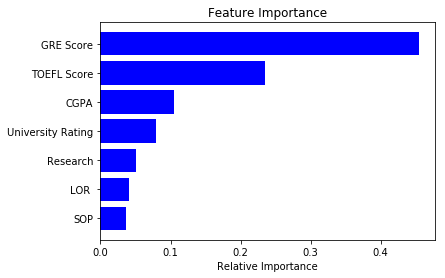

In [25]:
plt.figure(1)
plt.title('Feature Importance')
plt.barh(range(len(indices)), importances[indices], color='b',align='center')
plt.yticks(range(len(indices)), (np.array(features))[indices])
plt.xlabel('Relative Importance')

In [26]:
nb = NaiveBayes(labelCol="label", featuresCol="features")

stages_nb = stages

stages_nb[-2] = nb

pipeline_nb = Pipeline(stages = stages_nb)

# Build models
model_nb = pipeline_nb.fit(train)
results_nb = model_nb.transform(test)

print('Naive Bayes Model Precision = {:.2f}.'.format(results_nb.filter(results_nb.label == results_nb.prediction).count() / float(results_nb.count())))

Naive Bayes Model Precision = 0.81.


In [27]:
save(name='GraduateAdmissionsClassificationSparkML',
    model=model,
    test_data = test,
    algorithm_type='Classification',
    description='This is a SparkML Model to Classify Graduate Admission Chance of admit')

Using TensorFlow backend.


{'path': '/user-home/1008/DSX_Projects/Final_project/models/GraduateAdmissionsClassificationSparkML/2',
 'scoring_endpoint': 'https://dsxl-api/v3/project/score/Python36/spark-2.3/Final_project/GraduateAdmissionsClassificationSparkML/2'}

In [28]:
# Write the test data without label to a .csv so that we can later use it for batch scoring
write_score_CSV=test.toPandas().drop(['Chance of Admit '], axis=1)
write_score_CSV.to_csv('../datasets/GraduateAdmissionsSparkMLBatchScore.csv', sep=',', index=False)

In [29]:

# Write the test data to a .csv so that we can later use it for evaluation
write_eval_CSV=test.toPandas()
write_eval_CSV.to_csv('../datasets/GraduateAdmissionsSparkMLEval.csv', sep=',', index=False)